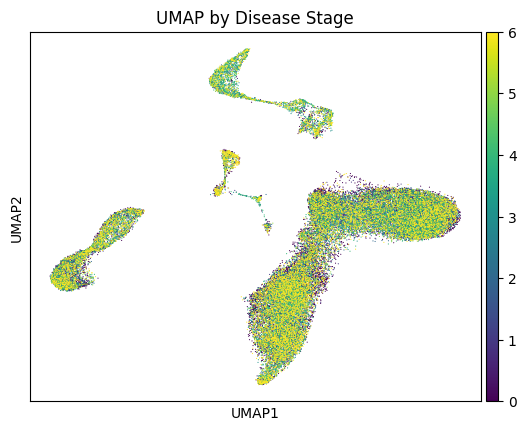

In [40]:
import matplotlib.pyplot as plt
import scanpy as sc

adata = sc.read_h5ad("nCoV_dataset_full.h5ad")

# Plot UMAP colored by patient group (Stage)
sc.pl.umap(adata, color="Stage", title="UMAP by Disease Stage", palette="Set2")


In [42]:
print(adata.X.shape)
print(adata.X)

(46022, 18824)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 37463747 stored elements and shape (46022, 18824)>
  Coords	Values
  (0, 6)	2.490055612984192
  (0, 7)	2.490055612984192
  (0, 72)	2.490055612984192
  (0, 74)	2.490055612984192
  (0, 98)	2.490055612984192
  (0, 138)	2.490055612984192
  (0, 188)	2.490055612984192
  (0, 207)	2.490055612984192
  (0, 223)	2.490055612984192
  (0, 238)	2.490055612984192
  (0, 244)	2.490055612984192
  (0, 248)	2.490055612984192
  (0, 250)	2.490055612984192
  (0, 252)	2.490055612984192
  (0, 262)	2.490055612984192
  (0, 294)	2.490055612984192
  (0, 419)	2.490055612984192
  (0, 422)	3.140866446808272
  (0, 433)	2.490055612984192
  (0, 470)	2.490055612984192
  (0, 491)	2.490055612984192
  (0, 520)	2.490055612984192
  (0, 602)	2.490055612984192
  (0, 611)	2.490055612984192
  (0, 642)	3.140866446808272
  :	:
  (46021, 12621)	1.3232427472144428
  (46021, 12623)	1.3232427472144428
  (46021, 12648)	1.8735176429864977
  (46021, 12649)	1.87351

In [43]:
print(adata.obs.keys())

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'percent.mt',
       'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage'],
      dtype='object')


In [45]:
# print(type(adata.obs))

# print(adata.obs["batch"].value_counts())

In [46]:
batch_to_condition = {
    0: "Ctrl-1",
    1: "Ctrl-2",
    2: "Ctrl-3",
    3: "IAV-1-D1",
    4: "IAV-1-D14",
    5: "IAV-2-D1",
    6: "IAV-2-D9",
    7: "COV-1-D1",
    8: "COV-1-D4",
    9: "COV-1-D16",
    10: "COV-2-D1",
    11: "COV-2-D4",
    12: "COV-2-D7",
    13: "COV-2-D10",
    14: "COV-2-D16",
    15: "COV-3-D1",
    16: "COV-3-D4",
    17: "COV-3-D16",
    18: "COV-4-D4",
    19: "COV-4-D16",
    20: "COV-5-D1",
    21: "COV-5-D7",
    22: "COV-5-D13",
}

# Add readable sample labels to adata.obs
adata.obs["sample_name"] = adata.obs["batch"].map(batch_to_condition)

# Then create higher-level condition labels from these
def categorize(sample):
    if sample.startswith("Ctrl"):
        return "Control"
    elif sample.startswith("COV"):
        return "COVID"
    elif sample.startswith("IAV"):
        return "IAV"
    else:
        return "Unknown"

adata.obs["condition"] = adata.obs["sample_name"].apply(categorize)

In [48]:
cell_type_mapping = {
    0: "Cytotoxic CD8 T cells",
    1: "Naive T cells",
    2: "NKs",
    3: "MAIT",
    4: "Activated CD4 T cells",
    5: "Naive B cells",
    6: "Plasma",
    7: "Memory B cells",
    8: "XCL+ NKs",
    9: "Cycling T cells",
    10: "Monocytes",
    11: "DCs",
    12: "Cycling Plasma",
    13: "Stem cells",
    14: "Megakaryocytes",
}

adata.obs["cell_type_name"] = adata.obs["cell_type"].map(cell_type_mapping)

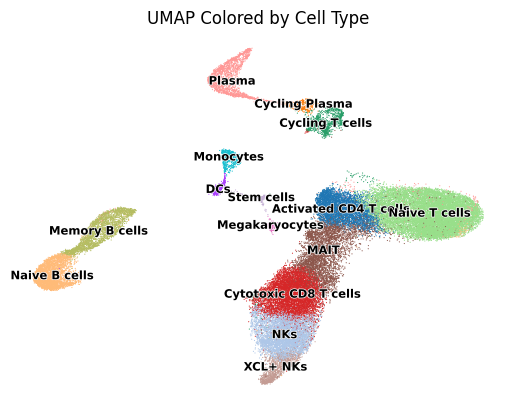

In [49]:
sc.pl.umap(
    adata,
    color="cell_type_name",
    legend_loc="on data",
    title="UMAP Colored by Cell Type",
    frameon=False,
    legend_fontsize="small",
    legend_fontoutline=1
)

/var/folders/2b/9ss_33w972731thsw5jz2w9m0000gn/T/ipykernel_24357/1964054.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_expr = df.groupby("sample_name").mean().loc[sample_order].T


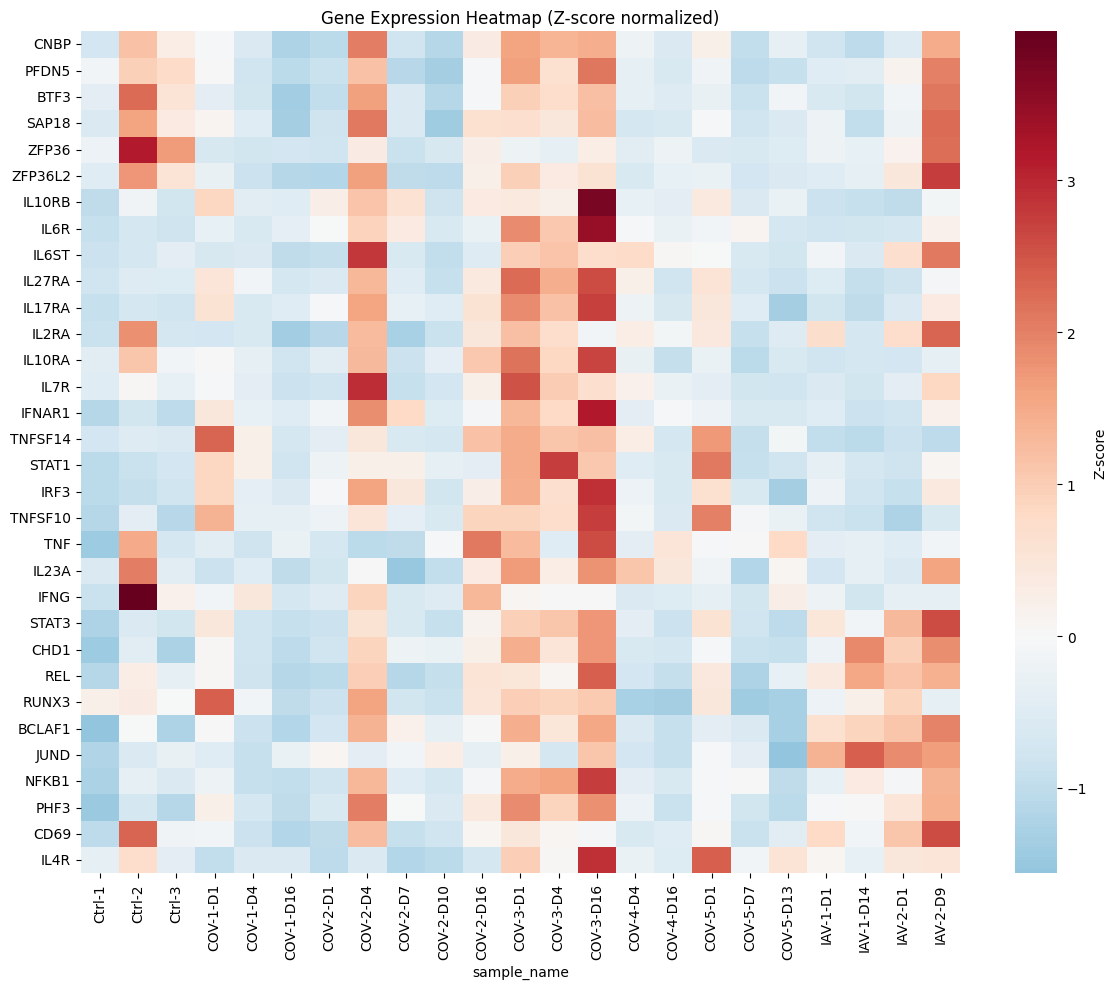

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# === Define gene list and sample order (from paper) ===
genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}

# Convert your gene list to indices
gene_indices = [gene_to_index[gene] for gene in genes]

sample_order = [
    "Ctrl-1", "Ctrl-2", "Ctrl-3",
    "COV-1-D1", "COV-1-D4", "COV-1-D16",
    "COV-2-D1", "COV-2-D4", "COV-2-D7", "COV-2-D10", "COV-2-D16",
    "COV-3-D1", "COV-3-D4", "COV-3-D16",
    "COV-4-D4", "COV-4-D16",
    "COV-5-D1", "COV-5-D7", "COV-5-D13",
    "IAV-1-D1", "IAV-1-D14", "IAV-2-D1", "IAV-2-D9"
]

# === Extract gene expression and sample labels ===
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order), :].copy()
X = adata_filtered.raw[:, gene_indices].X.toarray() if hasattr(adata_filtered.raw[:, gene_indices].X, "toarray") else adata_filtered.raw[:, genes].X
df = pd.DataFrame(X, columns=genes)
df["sample_name"] = adata_filtered.obs["sample_name"].values

# === Compute average expression per sample ===
avg_expr = df.groupby("sample_name").mean().loc[sample_order].T

# === Z-score each gene across samples ===
scaler = StandardScaler()
z_scores = pd.DataFrame(scaler.fit_transform(avg_expr.T).T, index=avg_expr.index, columns=avg_expr.columns)

# === Plot the heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(z_scores, cmap="RdBu_r", center=0, xticklabels=True, yticklabels=True, cbar_kws={"label": "Z-score"})
plt.xticks(rotation=90)
plt.title("Gene Expression Heatmap (Z-score normalized)")
plt.tight_layout()
plt.show()


In [52]:
target_genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

# Use .raw.var_names if available, otherwise fallback
gene_index = adata.raw.var["_index"].values  # Get the actual array of gene names
gene_index = [str(gene) for gene in gene_index]

found_genes = [g for g in target_genes if g in gene_index]
missing_genes = [g for g in target_genes if g not in gene_index]

print("Found genes:", found_genes)
print("Missing genes:", missing_genes)

Found genes: ['CNBP', 'PFDN5', 'BTF3', 'SAP18', 'ZFP36', 'ZFP36L2', 'IL10RB', 'IL6R', 'IL6ST', 'IL27RA', 'IL17RA', 'IL2RA', 'IL10RA', 'IL7R', 'IFNAR1', 'TNFSF14', 'STAT1', 'IRF3', 'TNFSF10', 'TNF', 'IL23A', 'IFNG', 'STAT3', 'CHD1', 'REL', 'RUNX3', 'BCLAF1', 'JUND', 'NFKB1', 'PHF3', 'CD69', 'IL4R']
Missing genes: []


In [53]:
print(adata.shape)

(46022, 18824)


In [54]:
print(adata.raw.var_names)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '18814', '18815', '18816', '18817', '18818', '18819', '18820', '18821',
       '18822', '18823'],
      dtype='object', length=18824)


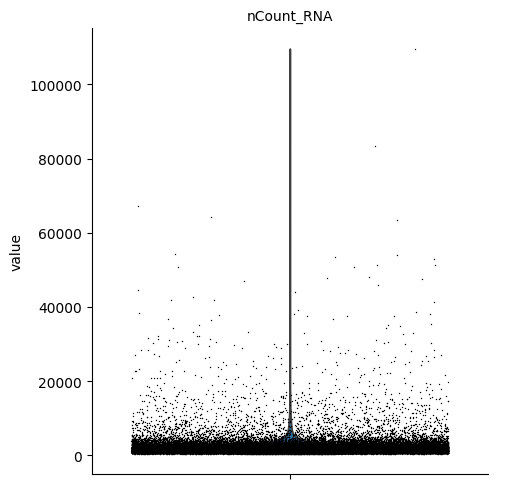

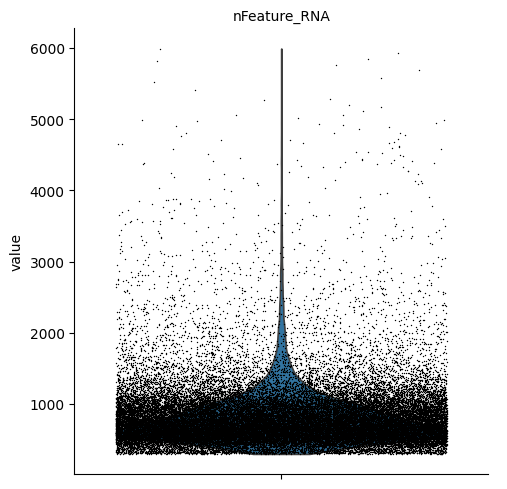

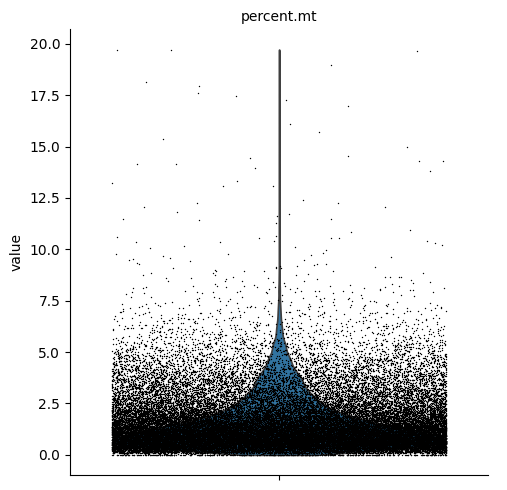

In [56]:
# Total counts per cell
sc.pl.violin(adata, ['nCount_RNA'], jitter=0.4, multi_panel=True)

# Number of detected genes per cell
sc.pl.violin(adata, ['nFeature_RNA'], jitter=0.4, multi_panel=True)

# Percent mitochondrial reads
sc.pl.violin(adata, ['percent.mt'], jitter=0.4, multi_panel=True)

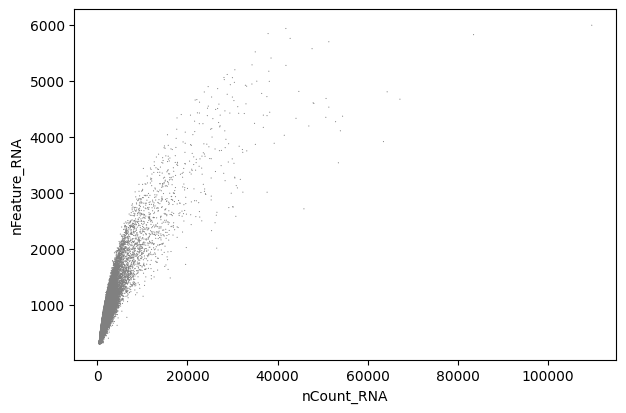

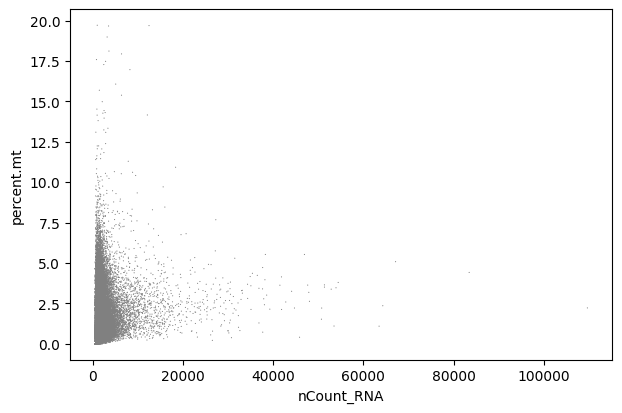

In [22]:
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA')
sc.pl.scatter(adata, x='nCount_RNA', y='percent.mt')

In [23]:
sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs['percent.mt'] < 20, :].copy()

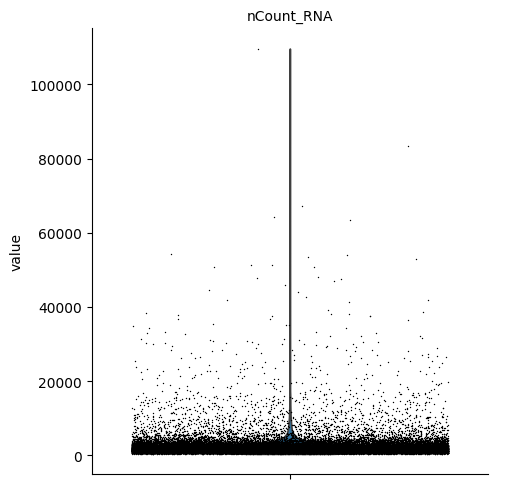

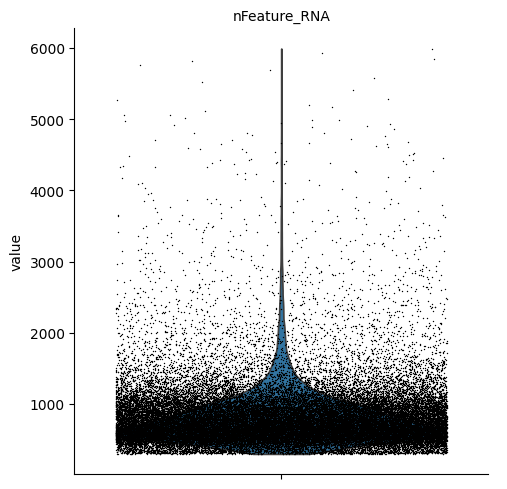

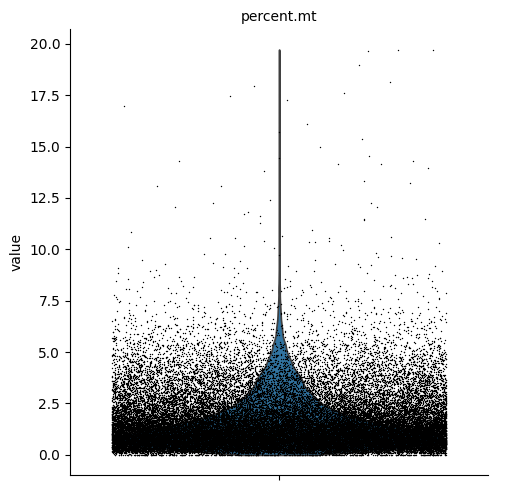

In [24]:
# Total counts per cell
sc.pl.violin(adata, ['nCount_RNA'], jitter=0.4, multi_panel=True)

# Number of detected genes per cell
sc.pl.violin(adata, ['nFeature_RNA'], jitter=0.4, multi_panel=True)

# Percent mitochondrial reads
sc.pl.violin(adata, ['percent.mt'], jitter=0.4, multi_panel=True)

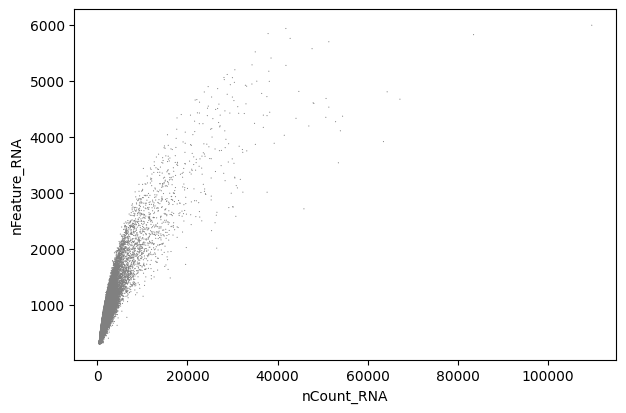

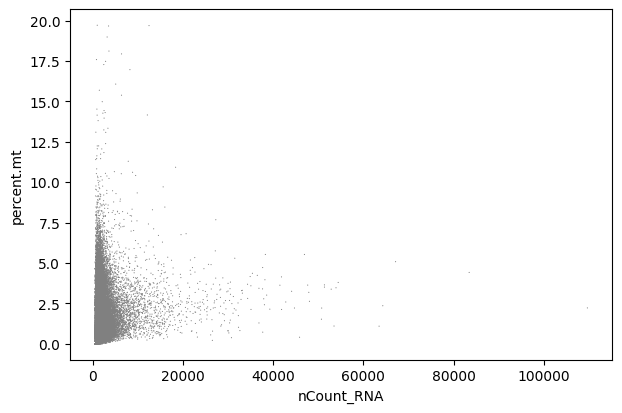

In [25]:
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA')
sc.pl.scatter(adata, x='nCount_RNA', y='percent.mt')

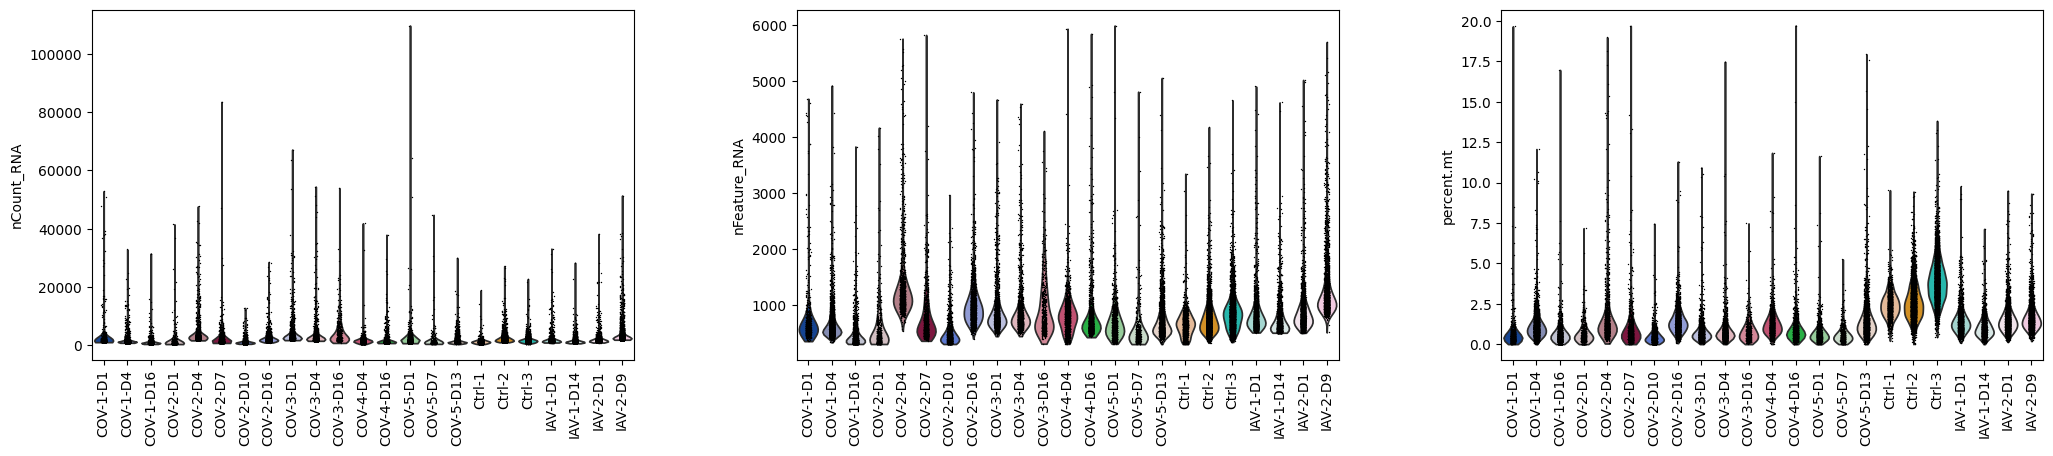

In [57]:
sc.pl.violin(adata, ['nCount_RNA', 'nFeature_RNA', 'percent.mt'], groupby='sample_name', rotation=90)


In [65]:
print(adata.obsm.keys())
print(adata.varm.keys())


KeysView(AxisArrays with keys: X_tsne, X_umap, X_pca)
KeysView(AxisArrays with keys: PCs)


In [59]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Find highly variable genes (optional, but common)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# Scale the data to unit variance (mean=0, std=1)
sc.pp.scale(adata, max_value=10)

In [61]:
sc.tl.pca(adata, svd_solver='arpack')

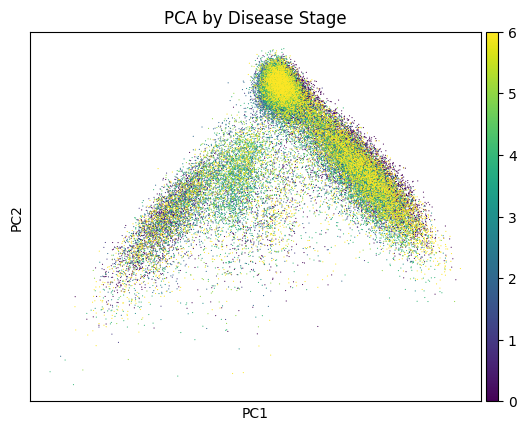

In [66]:
sc.pl.pca(adata, color="Stage", title="PCA by Disease Stage")


In [68]:
print(adata.obs.columns)

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'percent.mt',
       'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage',
       'sample_name', 'condition', 'cell_type_name'],
      dtype='object')


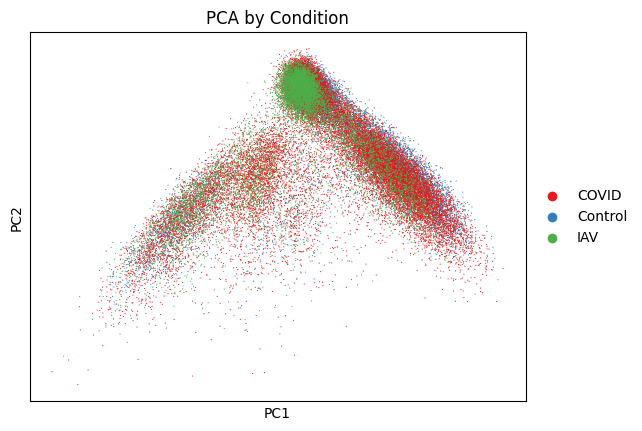

In [83]:
palette = ["#E41A1C", "#377EB8", "#4DAF4A"]
sc.pl.pca(adata, color="condition", title="PCA by Condition", palette=palette)


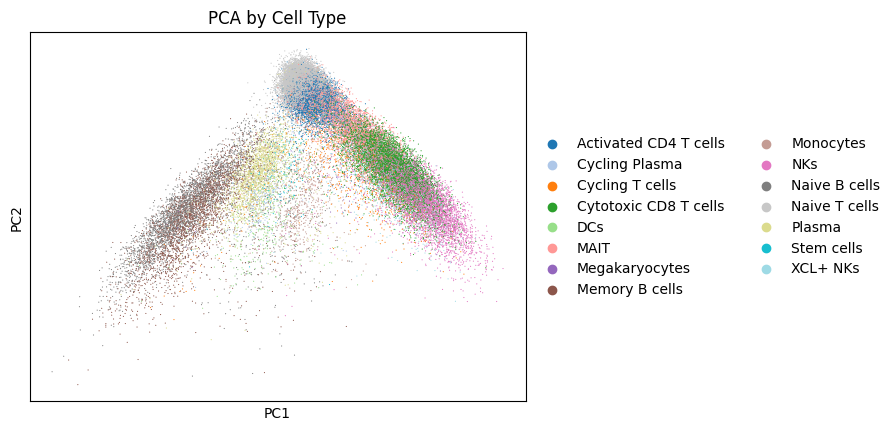

In [77]:
sc.pl.pca(adata, color="cell_type_name", title="PCA by Cell Type", palette="tab20")

In [89]:
# Step 1: Convert genes to indices
genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}
gene_indices = [gene_to_index[g] for g in genes]


In [85]:
# Add gene expression to .obs so we can use it in UMAP plots
import numpy as np

for gene, idx in zip(genes, gene_indices):
    expr = adata.raw.X[:, idx].toarray().flatten() if hasattr(adata.raw.X, "toarray") else adata.raw.X[:, idx]
    adata.obs[f"{gene}_expr"] = expr


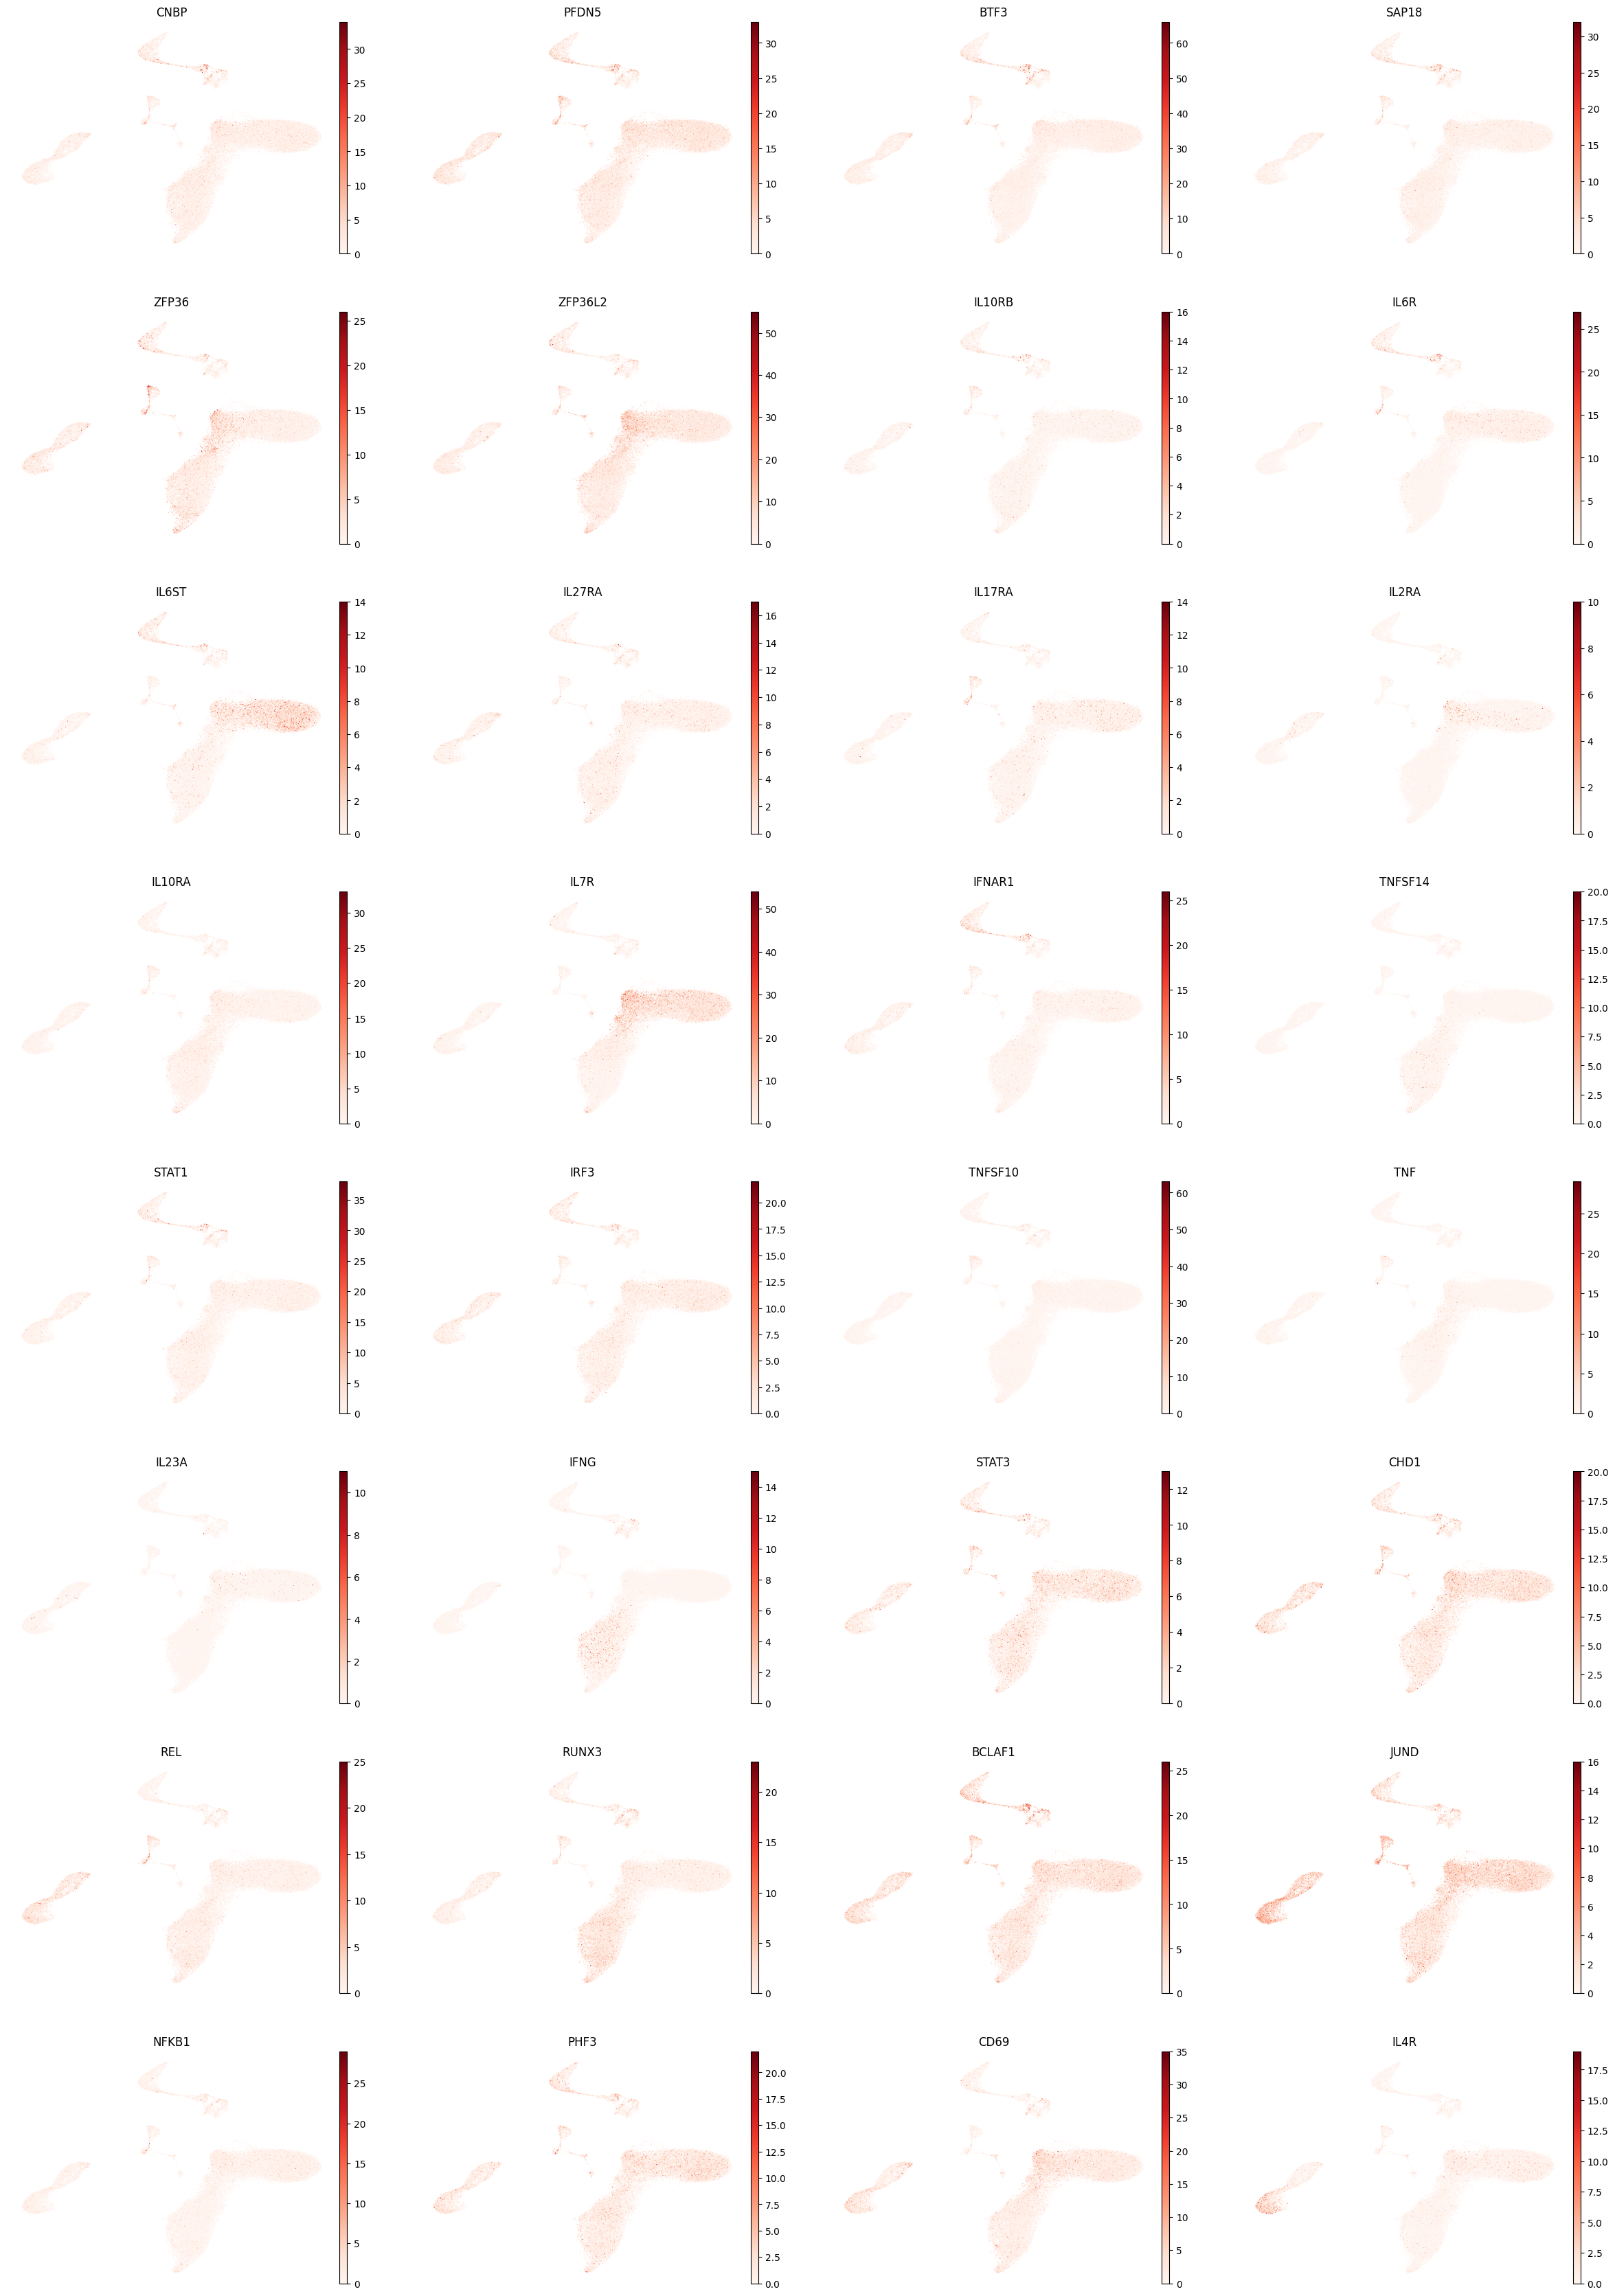

In [90]:
sc.pl.umap(
    adata,
    color=gene_indices,          # your list of 32 marker genes
    title=[f"{g}" for g in genes],
    ncols=4,              # display in grid
    cmap="Reds",          # expression color gradient
    use_raw=True,         # important since we stored full RNA in .raw
    frameon=False
)


In [95]:
sc.pp.normalize_total(adata, target_sum=1e4)

# Log1p transform (natural log)
sc.pp.log1p(adata)

sc.tl.rank_genes_groups(adata, groupby='condition', reference='Control', method='t-test')


/Users/jeremiah/QCB311-Final/env/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/Users/jeremiah/QCB311-Final/env/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:387: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [ ]:
!pip install gseapy

In [126]:
# If you're using `.raw`, which has 18824 genes:
gene_symbols = adata.raw.var["_index"].values  # These are actual gene names

# Then use the differential expression results to build a symbol-indexed rank list:
de_names = adata.uns['rank_genes_groups']['names']['COVID']
de_scores = adata.uns['rank_genes_groups']['logfoldchanges']['COVID']

# Convert names to strings (sometimes they're np.str_)

index_to_genes = {
    idx: gene for idx, gene in enumerate(adata.raw.var["_index"].values)
}
# print(de_names)
# print(index_to_genes)
gene_names = [index_to_genes[int(idx)] for idx in de_names]

# Build ranked list with gene symbols
rnk = pd.Series(data=de_scores, index=gene_names).dropna().sort_values(ascending=False)


In [127]:
print(adata.uns['rank_genes_groups']['names']['COVID'][:5])

['6686' '10636' '4325' '9992' '541']


In [128]:
import gseapy as gp

enr = gp.prerank(
    rnk=rnk,
    gene_sets="c2.cp.reactome.v2024.1.Hs.symbols.gmt",  # <- path to your .gmt file
    outdir=None,
    min_size=15,
    max_size=500,
    permutation_num=100,
    seed=42
)

2025-04-19 15:30:55,255 [WARNING] Duplicated values found in preranked stats: 24.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [129]:
print(enr.res2d.columns)

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')


<Axes: title={'center': 'Reactome Enrichment - COVID vs Control'}, xlabel='$- \\log_{10}$ (FDR q-val)'>

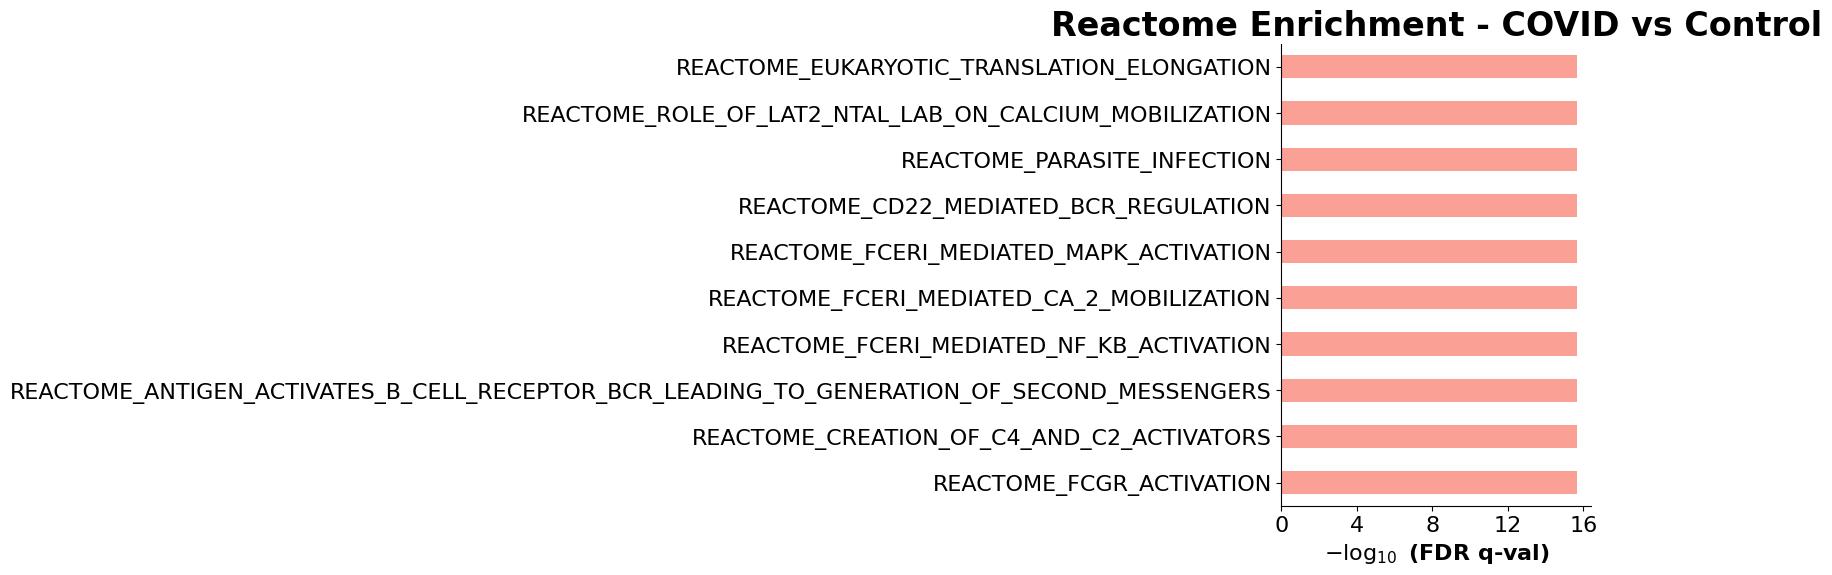

In [130]:
gp.barplot(enr.res2d, column='FDR q-val', title='Reactome Enrichment - COVID vs Control', cutoff=0.05)

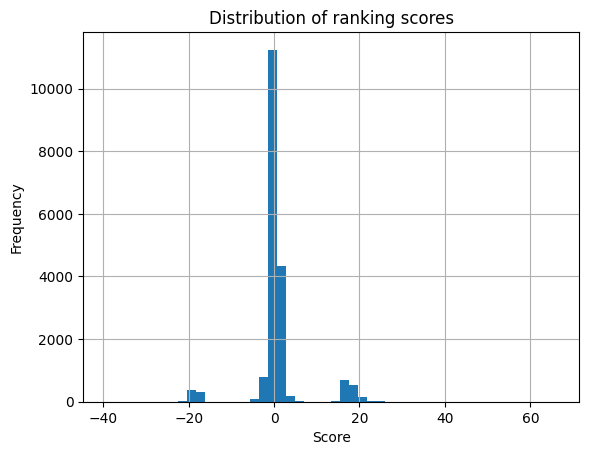

In [131]:
import matplotlib.pyplot as plt

rnk.hist(bins=50)
plt.title("Distribution of ranking scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [132]:
print(enr.res2d[['Term', 'FDR q-val']].sort_values('FDR q-val').head(20))


                                                 Term FDR q-val
0          REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION       0.0
19  REACTOME_ROLE_OF_LAT2_NTAL_LAB_ON_CALCIUM_MOBI...       0.0
18                        REACTOME_PARASITE_INFECTION       0.0
17              REACTOME_CD22_MEDIATED_BCR_REGULATION       0.0
15     REACTOME_ROLE_OF_PHOSPHOLIPIDS_IN_PHAGOCYTOSIS       0.0
14          REACTOME_FCERI_MEDIATED_CA_2_MOBILIZATION       0.0
13           REACTOME_FCERI_MEDIATED_NF_KB_ACTIVATION       0.0
12  REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_BCR...       0.0
11          REACTOME_CREATION_OF_C4_AND_C2_ACTIVATORS       0.0
10                           REACTOME_FCGR_ACTIVATION       0.0
16            REACTOME_FCERI_MEDIATED_MAPK_ACTIVATION       0.0
1                REACTOME_SELENOAMINO_ACID_METABOLISM       0.0
9             REACTOME_FCGR3A_MEDIATED_IL10_SYNTHESIS       0.0
2   REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACI...       0.0
22      REACTOME_SIGNALING_BY_THE_B_CELL

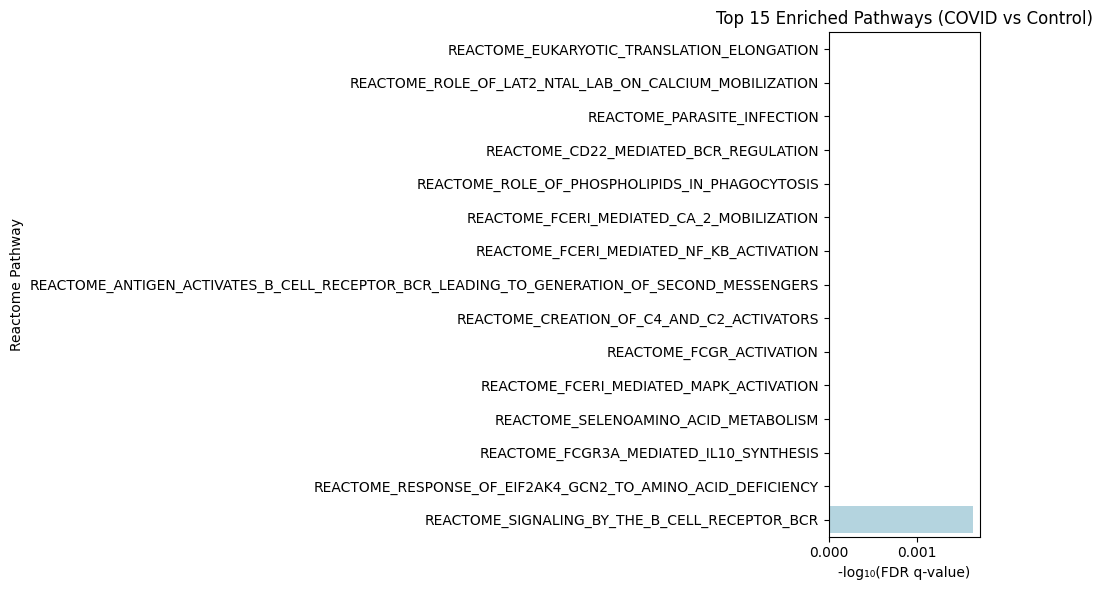

In [134]:
# Filter the top results for better readability
top_terms = enr.res2d.sort_values('FDR q-val').head(15)

# Rename for clarity
top_terms = top_terms.rename(columns={'FDR q-val': 'FDR_qval'})

# Plot using matplotlib directly
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_terms,
    x=top_terms['FDR_qval'] + 1e-6,  # avoid -inf
    y='Term',
    color="lightblue"
)
plt.xlabel('-log₁₀(FDR q-value)')
plt.ylabel('Reactome Pathway')
plt.title('Top 15 Enriched Pathways (COVID vs Control)')
plt.tight_layout()
plt.show()
